In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

# Load the data
df = pd.read_csv('FinalDataset.csv')

# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Separate features and target variable
X = df.drop('Price', axis=1)
y = df['Price']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


Dataset shape: (2466, 10)

First few rows:
   Brand  SSD_Capacity   RAM  Graphics_Card  Operating_System  \
0     48         512.0  16.0              5                 0   
1     10         512.0  16.0             42                 4   
2     48         512.0  16.0              9                 0   
3     10         256.0  32.0              9                 4   
4     48         512.0  16.0              5                 0   

   Graphics_Memory_Type  Graphics_Card_Type  Processor_Core_Count  \
0                     5                   0                   4.0   
1                     2                   0                   4.0   
2                     5                   0                   4.0   
3                     5                   0                   6.0   
4                     5                   0                   4.0   

   Graphics_Card_Memory     Price  
0                   4.0  13716.90  
1                   4.0  13678.00  
2                   4.0  12857.74  
3      


=== Decision Tree Hyperparameter Tuning ===

Best Decision Tree Parameters: {'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 2}
Best Decision Tree MSE Score: 107389580.61


<Figure size 1200x800 with 0 Axes>

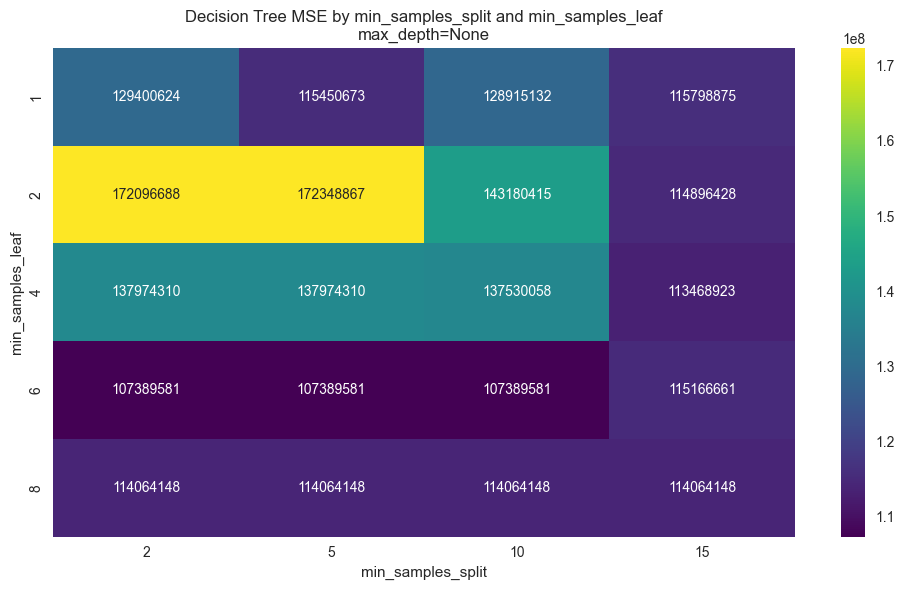

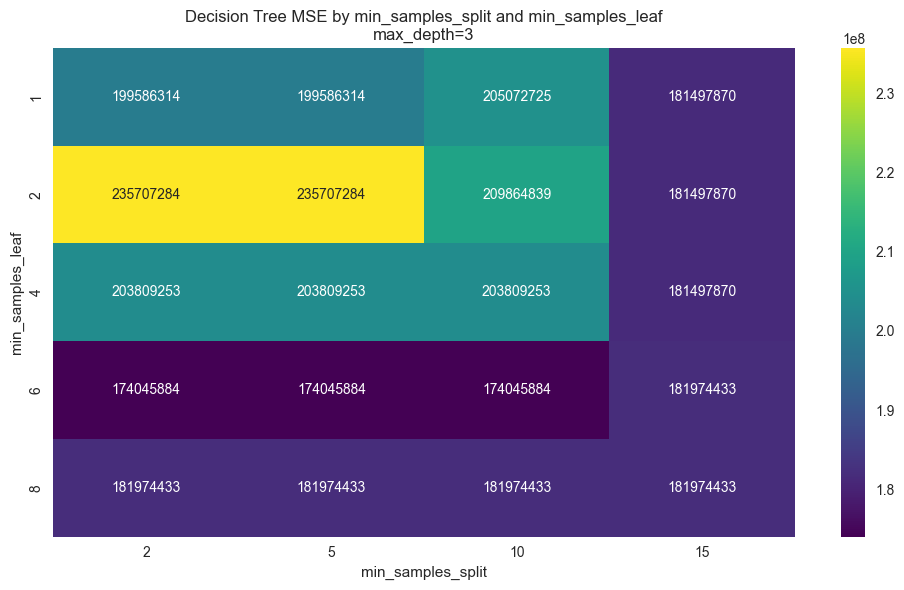

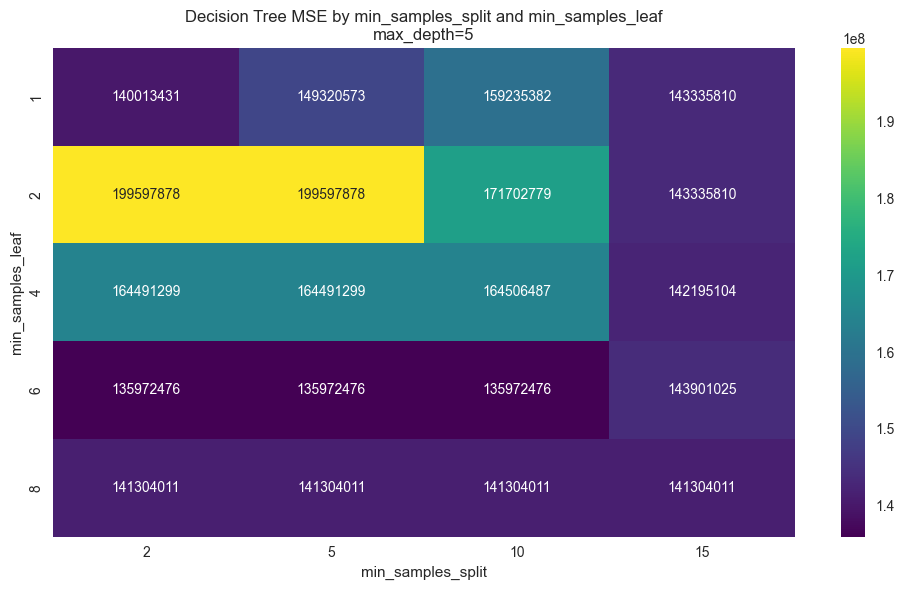

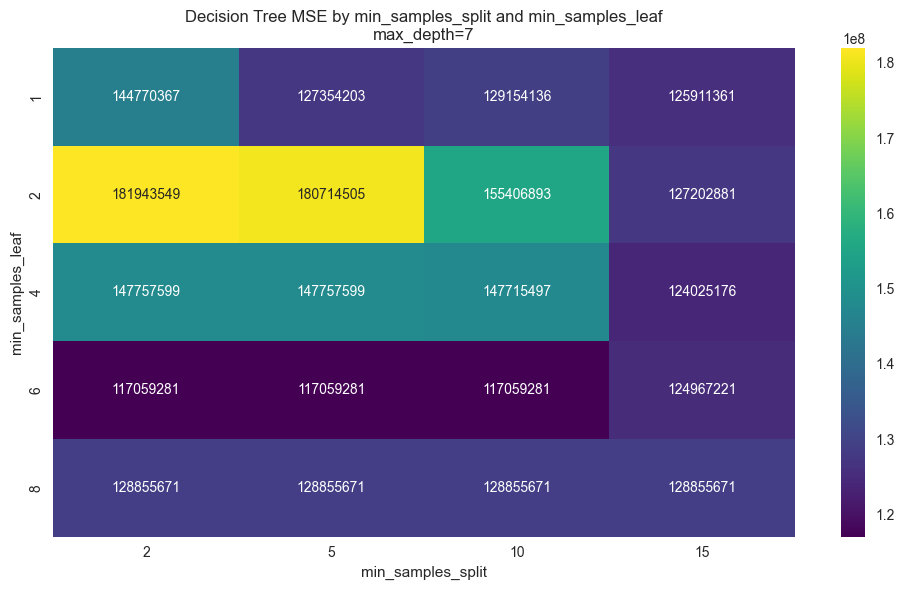

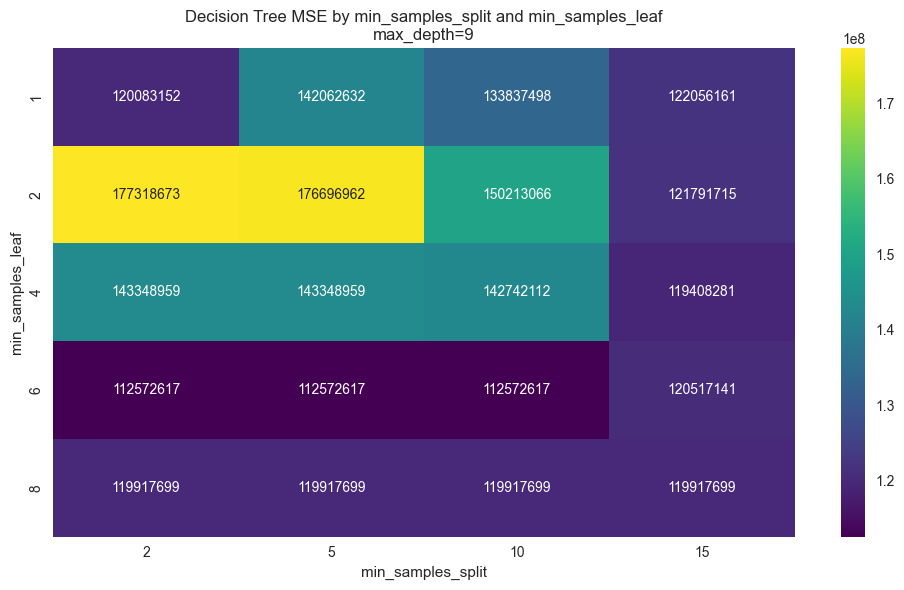

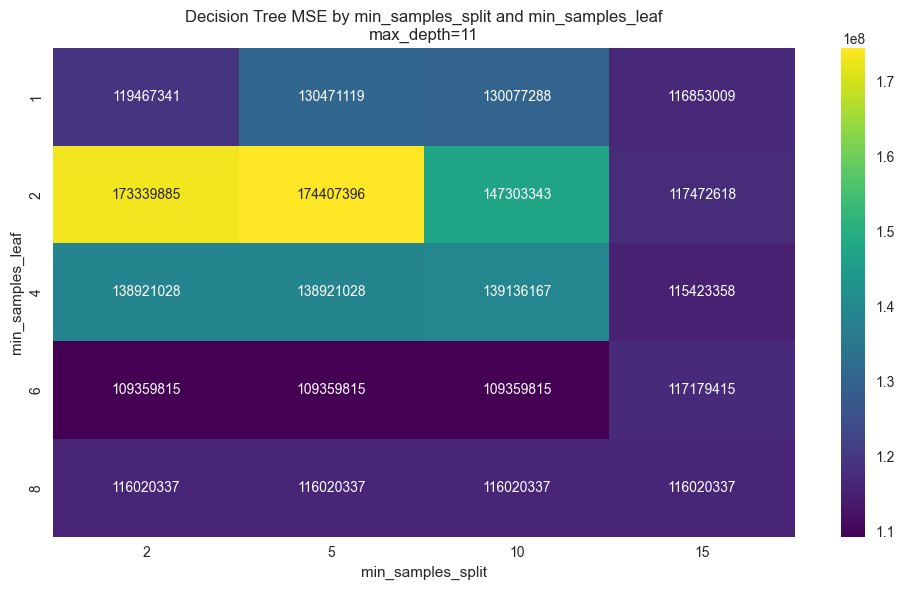


Best Decision Tree Performance Metrics:
Mean Squared Error (MSE): 59845430.06
Root Mean Squared Error (RMSE): 7735.98
Mean Absolute Error (MAE): 3538.84
R² Score: 0.7724
Adjusted R²: 0.7681


In [3]:

# # Function to evaluate model performance
# def evaluate_model(model, X_test, y_test, model_name):
#     """Evaluate model performance and return metrics"""
#     y_pred = model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
    
#     print(f"\n{model_name} Performance Metrics:")
#     print(f"Mean Squared Error (MSE): {mse:.2f}")
#     print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
#     print(f"Mean Absolute Error (MAE): {mae:.2f}")
#     print(f"R² Score: {r2:.4f}")
    
#     return mse, rmse, mae, r2, y_pred

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance and return metrics, including Adjusted R²"""
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Adjusted R²
    n = len(y_test)  # number of samples
    p = X_test.shape[1]  # number of features
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # Print performance metrics
    print(f"\n{model_name} Performance Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Adjusted R²: {adj_r2:.4f}")
    
    return mse, rmse, mae, r2, adj_r2, y_pred


# Decision Tree Hyperparameter Tuning
print("\n=== Decision Tree Hyperparameter Tuning ===")

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [None, 3, 5, 7, 9, 11],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Create Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)

# Create grid search object
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid,
                            cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Train the model with grid search
dt_grid_search.fit(X_train, y_train)

# Best parameters and best score
print("\nBest Decision Tree Parameters:", dt_grid_search.best_params_)
print("Best Decision Tree MSE Score: {:.2f}".format(-dt_grid_search.best_score_))

# Plot decision tree hyperparameter tuning results
results_dt = pd.DataFrame(dt_grid_search.cv_results_)

# Extract results for each max_depth value
plt.figure(figsize=(12, 8))
for depth in dt_param_grid['max_depth']:
    if depth is None:
        depth_str = 'None'
    else:
        depth_str = str(depth)
    
    # Filter results for this depth
    depth_results = results_dt[results_dt['param_max_depth'].astype(str) == depth_str]
    
    # Get mean test scores for this depth and min_samples_split combinations
    pivot_table = depth_results.pivot_table(
        values='mean_test_score', 
        index='param_min_samples_leaf',
        columns='param_min_samples_split'
    )
    
    # Convert negative MSE to positive for better interpretability
    pivot_table = -pivot_table
    
    # Plot heatmap for this depth
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='viridis')
    plt.title(f'Decision Tree MSE by min_samples_split and min_samples_leaf\nmax_depth={depth_str}')
    plt.ylabel('min_samples_leaf')
    plt.xlabel('min_samples_split')
    plt.tight_layout()
    plt.show()

# Get the best Decision Tree model
best_dt_model = dt_grid_search.best_estimator_

# Evaluate the best Decision Tree model
dt_mse, dt_rmse, dt_mae, dt_r2, dt_adjr2,dt_y_pred = evaluate_model(best_dt_model, X_test, y_test, "Best Decision Tree")

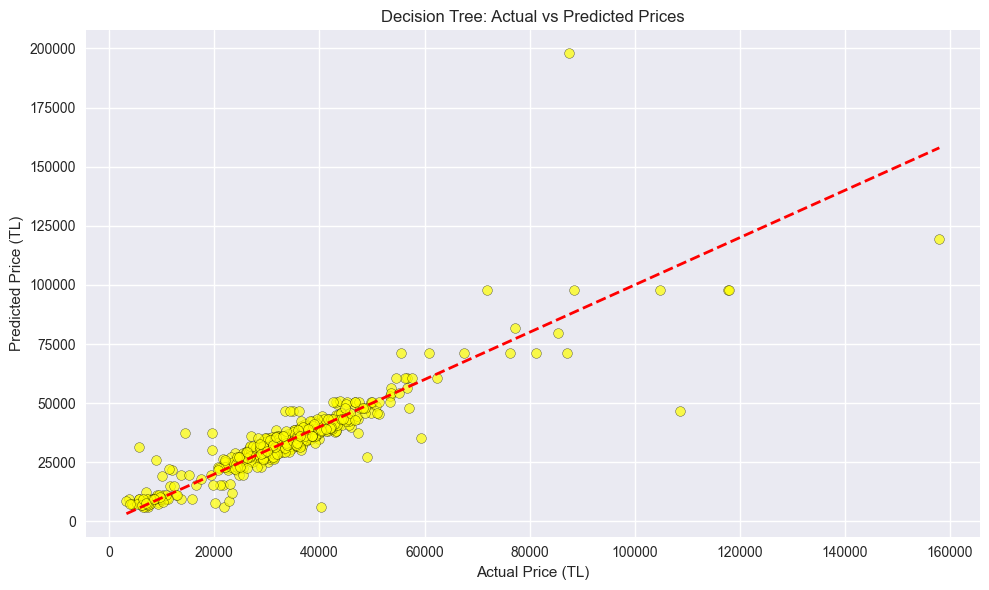

In [5]:
# Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, dt_y_pred, alpha=0.7, color='yellow', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Decision Tree: Actual vs Predicted Prices')
plt.xlabel('Actual Price (TL)')
plt.ylabel('Predicted Price (TL)')
plt.grid(True)
plt.tight_layout()
plt.show()



=== Random Forest Hyperparameter Tuning ===

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest MSE Score: 85520970.36


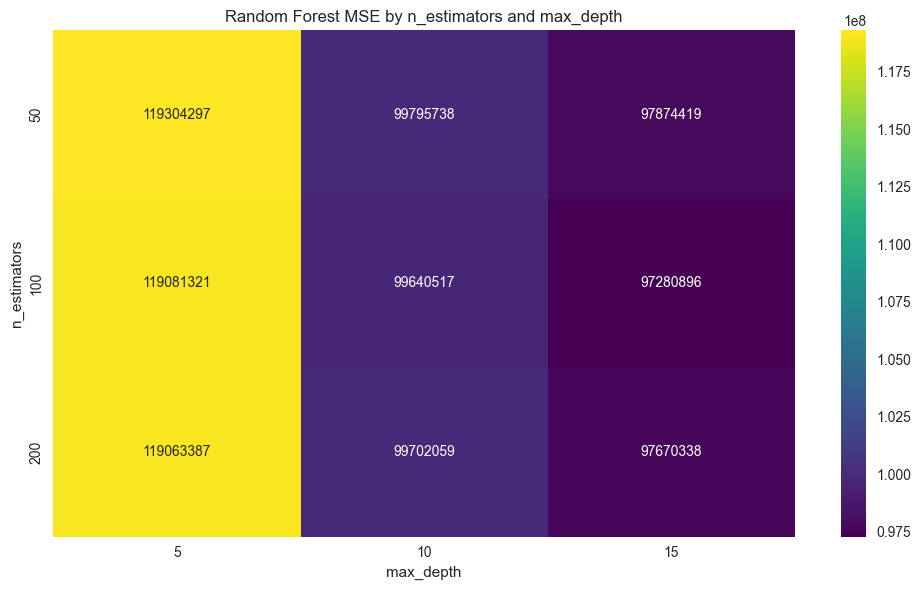

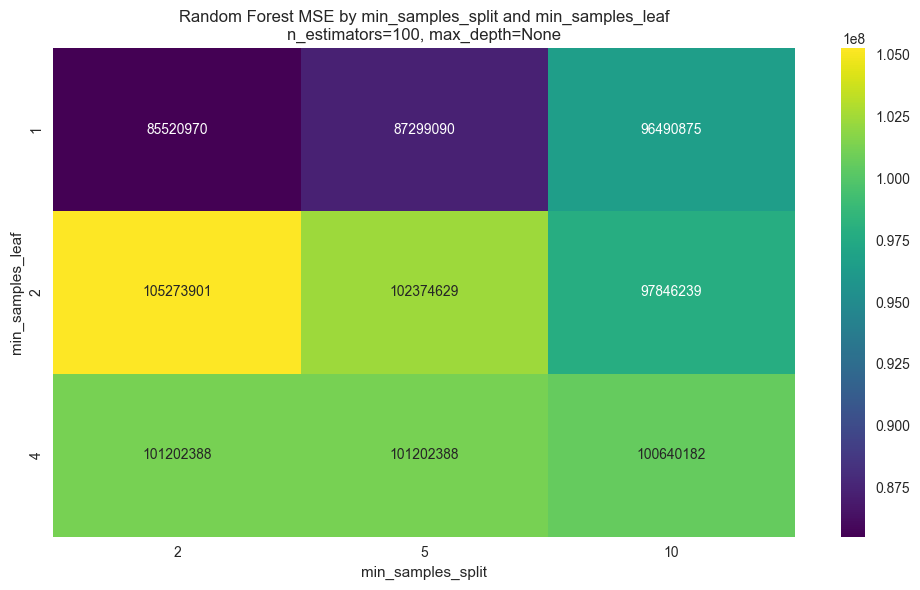


Best Random Forest Performance Metrics:
Mean Squared Error (MSE): 32449069.00
Root Mean Squared Error (RMSE): 5696.41
Mean Absolute Error (MAE): 3038.52
R² Score: 0.8766
Adjusted R²: 0.8743


In [4]:


# Random Forest Hyperparameter Tuning
print("\n=== Random Forest Hyperparameter Tuning ===")

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Create grid search object
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid,
                            cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Train the model with grid search
rf_grid_search.fit(X_train, y_train)

# Best parameters and best score
print("\nBest Random Forest Parameters:", rf_grid_search.best_params_)
print("Best Random Forest MSE Score: {:.2f}".format(-rf_grid_search.best_score_))

# Plot Random Forest hyperparameter tuning results for n_estimators and max_depth
results_rf = pd.DataFrame(rf_grid_search.cv_results_)

# Calculate average MSE for each n_estimators and max_depth combination
rf_scores = results_rf.groupby(['param_n_estimators', 'param_max_depth'])['mean_test_score'].mean().reset_index()
rf_scores['mean_test_score'] = -rf_scores['mean_test_score']  # Convert negative MSE to positive
rf_pivot = rf_scores.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(rf_pivot, annot=True, fmt='.0f', cmap='viridis')
plt.title('Random Forest MSE by n_estimators and max_depth')
plt.ylabel('n_estimators')
plt.xlabel('max_depth')
plt.tight_layout()
plt.show()

# Plot for min_samples_split and min_samples_leaf
best_n_est = rf_grid_search.best_params_['n_estimators']
best_depth = rf_grid_search.best_params_['max_depth']

# Filter results for the best n_estimators and max_depth
best_combo_results = results_rf[
    (results_rf['param_n_estimators'] == best_n_est) & 
    (results_rf['param_max_depth'].astype(str) == str(best_depth))
]

# Create pivot table
rf_leaf_split_pivot = best_combo_results.pivot_table(
    values='mean_test_score',
    index='param_min_samples_leaf',
    columns='param_min_samples_split'
)
rf_leaf_split_pivot = -rf_leaf_split_pivot  # Convert to positive MSE

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(rf_leaf_split_pivot, annot=True, fmt='.0f', cmap='viridis')
plt.title(f'Random Forest MSE by min_samples_split and min_samples_leaf\nn_estimators={best_n_est}, max_depth={best_depth}')
plt.ylabel('min_samples_leaf')
plt.xlabel('min_samples_split')
plt.tight_layout()
plt.show()

# Get the best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

# Evaluate the best Random Forest model
rf_mse, rf_rmse, rf_mae, rf_r2, rf2_adjr2,rf_y_pred = evaluate_model(best_rf_model, X_test, y_test, "Best Random Forest")



=== Model Comparison ===
                        MSE         RMSE          MAE        R²  Adjusted R2
Decision Tree  5.984543e+07  7735.982812  3538.839068  0.772369     0.768136
Random Forest  3.244907e+07  5696.408430  3038.522113  0.876575     0.874280

Best model based on Adjusted R² score: Random Forest


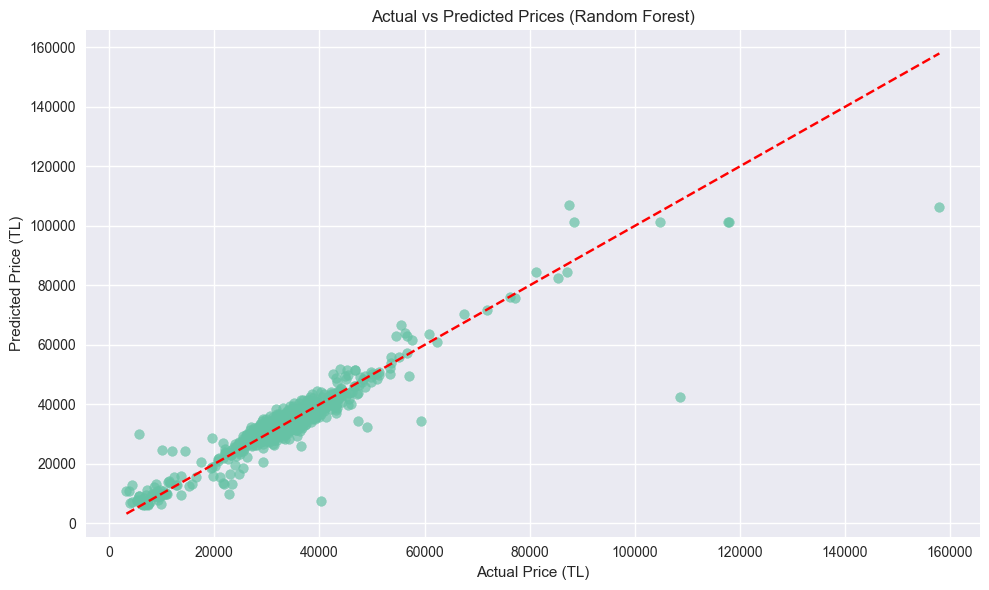

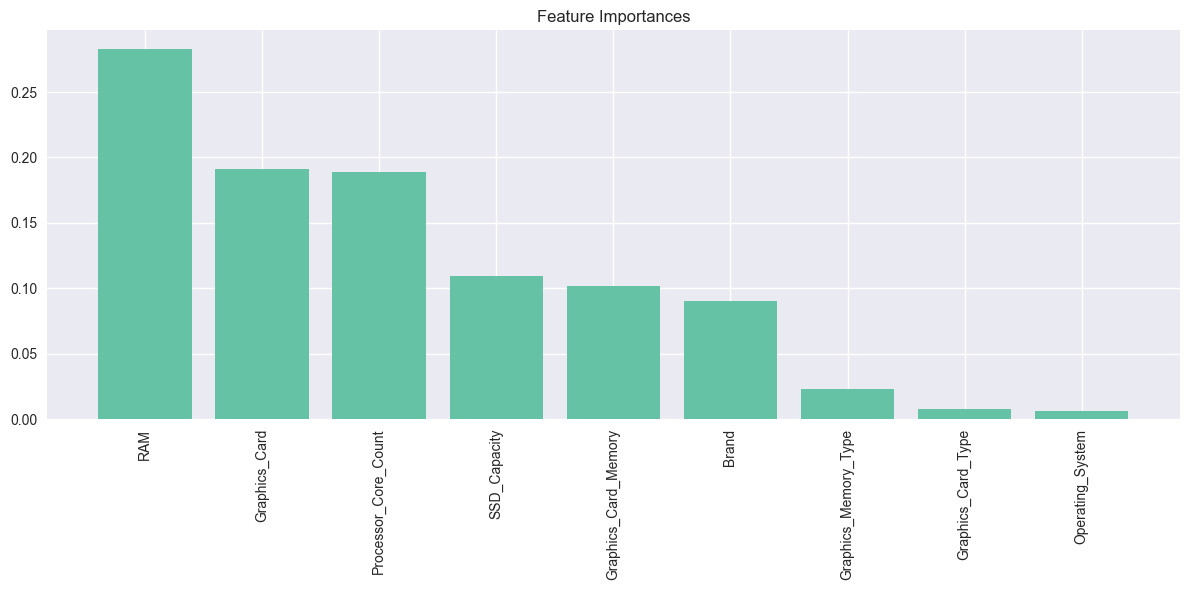


=== Final Evaluation ===
The Random Forest model performed better in predicting desktop computer prices.
Key metrics for Random Forest:
  - MSE: 32449069.00
  - RMSE: 5696.41 TL
  - MAE: 3038.52 TL
  - R²: 0.8766
  - Adjusted R²: 0.8743

Reasons for model superiority:
- Random Forest's ensemble approach reduces overfitting
- By averaging multiple decision trees, Random Forest provides more stable predictions
- Random Forest naturally handles the complex relationships between features and price


In [5]:

# Compare models
print("\n=== Model Comparison ===")
models = ['Decision Tree', 'Random Forest']
metrics = {
    'MSE': [dt_mse, rf_mse],
    'RMSE': [dt_rmse, rf_rmse],
    'MAE': [dt_mae, rf_mae],
    'R²': [dt_r2, rf_r2],
    'Adjusted R2':[dt_adjr2,rf2_adjr2]
}

comparison_df = pd.DataFrame(metrics, index=models)
print(comparison_df)

# Determine the best model
best_model_name = "Random Forest" if rf2_adjr2 > dt_adjr2 else "Decision Tree"
print(f"\nBest model based on Adjusted R² score: {best_model_name}")

# Plot actual vs predicted values for the best model
if best_model_name == "Random Forest":
    best_pred = rf_y_pred
    best_model = best_rf_model
else:
    best_pred = dt_y_pred
    best_model = best_dt_model

plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title(f'Actual vs Predicted Prices ({best_model_name})')
plt.xlabel('Actual Price (TL)')
plt.ylabel('Predicted Price (TL)')
plt.tight_layout()
plt.show()

# Feature importance for the best model
if best_model_name == "Random Forest":
    # Get feature importances from Random Forest
    importances = best_model.feature_importances_
    feature_names = X.columns
    
    # Sort importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
else:
    # Get feature importances from Decision Tree
    importances = best_model.feature_importances_
    feature_names = X.columns
    
    # Sort importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Final remarks on model comparison
print("\n=== Final Evaluation ===")
print(f"The {best_model_name} model performed better in predicting desktop computer prices.")
print(f"Key metrics for {best_model_name}:")
if best_model_name == "Random Forest":
    print(f"  - MSE: {rf_mse:.2f}")
    print(f"  - RMSE: {rf_rmse:.2f} TL")
    print(f"  - MAE: {rf_mae:.2f} TL")
    print(f"  - R²: {rf_r2:.4f}")
    print(f"  - Adjusted R²: {rf2_adjr2:.4f}")
else:
    print(f"  - MSE: {dt_mse:.2f}")
    print(f"  - RMSE: {dt_rmse:.2f} TL")
    print(f"  - MAE: {dt_mae:.2f} TL")
    print(f"  - R²: {dt_r2:.4f}")
    print(f"  - Adjusted R²: {dt_adjr2:.4f}")

print("\nReasons for model superiority:")
if best_model_name == "Random Forest":
    print("- Random Forest's ensemble approach reduces overfitting")
    print("- By averaging multiple decision trees, Random Forest provides more stable predictions")
    print("- Random Forest naturally handles the complex relationships between features and price")
else:
    print("- The simpler Decision Tree model captured the price patterns effectively")
    print("- Decision Tree may have found key splitting features that strongly determine price")
    print("- The optimized hyperparameters helped prevent overfitting")


=== Performance across Price Segments ===
          Absolute Error          Percentage Error       
                    mean   median             mean median
Segment                                                  
Budget           2611.90  1732.74            21.36   9.27
Mid-range        2530.86  2491.10             7.72   7.44
High-end         3969.73  2179.81             7.33   4.80


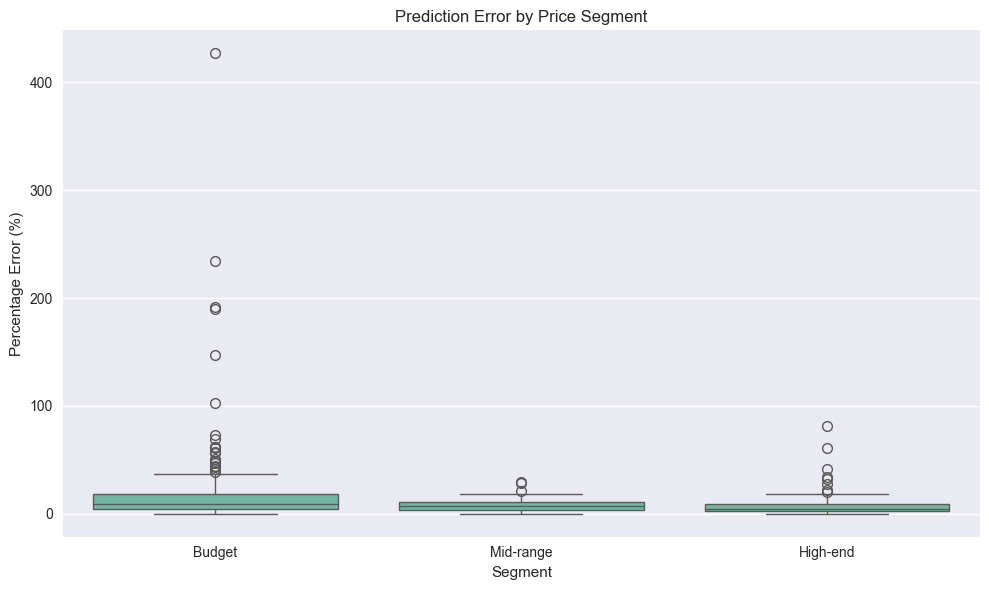

In [7]:
# Segment analysis - performance across different price segments
residuals = y_test - best_pred
relative_errors = np.abs(residuals / y_test)

price_segments = pd.qcut(y_test, q=3, labels=['Budget', 'Mid-range', 'High-end'])

segment_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': best_pred,
    'Absolute Error': np.abs(residuals),
    'Percentage Error': relative_errors * 100,
    'Segment': price_segments
})

segment_performance = segment_df.groupby('Segment').agg({
    'Absolute Error': ['mean', 'median'],
    'Percentage Error': ['mean', 'median']
}).round(2)

print("\n=== Performance across Price Segments ===")
print(segment_performance)

# Optional: Visualize error by segment
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='Percentage Error', data=segment_df)
plt.title('Prediction Error by Price Segment')
plt.ylabel('Percentage Error (%)')
plt.tight_layout()
plt.show()


In [8]:
# Print top 10 features
print(f"\nTop 10 important features for {best_model_name}:")
for i in range(min(10, len(indices))):
    feature = feature_names[indices[i]]
    importance = importances[indices[i]]
    print(f"{i+1}. {feature}: {importance:.4f}")




Top 10 important features for Random Forest:
1. RAM: 0.2830
2. Graphics_Card: 0.1915
3. Processor_Core_Count: 0.1887
4. SSD_Capacity: 0.1091
5. Graphics_Card_Memory: 0.1014
6. Brand: 0.0901
7. Graphics_Memory_Type: 0.0229
8. Graphics_Card_Type: 0.0076
9. Operating_System: 0.0058
